**Deepwalk**

Deepwalk is an algorithm based on **skip-gram**, which is at first only used in the field of word embedding. Normally, node will have **similar features** as their **neighbors**. In this case, if we start at a random node and use DFS to walk randomly to get a sequence of nodes, we could get a "sentence" formed by nodes. After that, we could perform skip-gram algorithm on each "node sentence" to get embedding for each node. 

In [ ]:
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Karate club graph is a classic dataset for graph research. A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972. The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. During the study a conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. (from Wikipedia)

In [ ]:
G = nx.karate_club_graph()
print("number of nodes: {0}".format(G.number_of_nodes()))
print("number of edges: {0}".format(G.number_of_edges()))

number of nodes: 34
number of edges: 78


In [ ]:
walk_len = 10
walk_num = 10
walks = []
for node in G.nodes:
  walk_count = 0
  while(walk_count < walk_num):
    node_count = 0
    step = node
    walk = []
    while(node_count < walk_len):
      walk.append(step)
      step = random.sample([neighbor for neighbor in G.neighbors(step)], 1)[0]
      node_count += 1
    walks.append(walk)
    walk_count += 1
print("number of walks: {0}".format(len(walks)))
print(walks[0])

number of walks: 340
[0, 7, 0, 13, 0, 1, 0, 8, 32, 23]


In [ ]:
epoch = 500
windowsz = 2
lr = 0.01
batch = 64
wordsz = G.number_of_nodes()
featuresz = 32

In [ ]:
def one_hot(node):
  vec = [0] * wordsz
  vec[node] = 1
  return vec

def gen_data(walks):
  sources = []
  targets = []
  for walk in walks:
    for i, node in enumerate(walk):
      source = one_hot(node)
      for j in range(i - windowsz, i + windowsz + 1):
        if j != i and j >= 0 and j < len(walk):
          target = walk[j]
          sources.append(source)
          targets.append(target)
  return torch.Tensor(sources), torch.tensor(targets)

sources, targets = gen_data(walks)

In [ ]:
print(sources.shape)

torch.Size([11560, 34])


The model is the same as word2vec. The only difference is the dataset.

In [ ]:
class Deepwalk(nn.Module):
  def __init__(self):
    super(Deepwalk, self).__init__()
    self.layer1 = nn.Linear(wordsz, featuresz)
    self.layer2 = nn.Linear(featuresz, wordsz)
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    return x

In [ ]:
model = Deepwalk()
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
trainset = torch.utils.data.TensorDataset(sources, targets)
train_loader = DataLoader(trainset, batch_size=batch, shuffle=True)

In [ ]:
def train():
  model.train()
  for i in range(epoch):
    acc = 0
    for x, y in train_loader:
      pred = model(x)
      loss = criterion(pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print("epoch: {0}, loss: {1}".format(i, loss))

In [ ]:
train()

epoch: 0, loss: 3.490615129470825
epoch: 1, loss: 3.457383394241333
epoch: 2, loss: 3.313511371612549
epoch: 3, loss: 3.273717164993286
epoch: 4, loss: 3.3553528785705566
epoch: 5, loss: 3.2623252868652344
epoch: 6, loss: 3.3083832263946533
epoch: 7, loss: 3.1874661445617676
epoch: 8, loss: 3.2265944480895996
epoch: 9, loss: 3.0936403274536133
epoch: 10, loss: 3.3168997764587402
epoch: 11, loss: 3.2272002696990967
epoch: 12, loss: 3.343945264816284
epoch: 13, loss: 3.1502645015716553
epoch: 14, loss: 3.2152068614959717
epoch: 15, loss: 3.1861350536346436
epoch: 16, loss: 3.059507131576538
epoch: 17, loss: 3.29246187210083
epoch: 18, loss: 3.2299468517303467
epoch: 19, loss: 2.954097270965576
epoch: 20, loss: 3.3094024658203125
epoch: 21, loss: 3.2160675525665283
epoch: 22, loss: 3.333824634552002
epoch: 23, loss: 3.2804741859436035
epoch: 24, loss: 3.2854557037353516
epoch: 25, loss: 3.3216395378112793
epoch: 26, loss: 3.083930730819702
epoch: 27, loss: 3.3353848457336426
epoch: 28, lo

In [ ]:
embedding = model.layer1.weight.T
similaity = F.cosine_similarity(embedding.unsqueeze(1), embedding.unsqueeze(0), dim=2)
a, idx = torch.sort(similaity, descending=True)
k = 4
lists=idx[:,1:k+1]
for i in range(G.number_of_nodes()):
  print("[{0}] is similar to ".format(i), end="")
  for j in range(k):
    print("[{0}]".format(int(lists[i][j])), end=" ")
  print()

[0] is similar to [10] [17] [11] [21] 
[1] is similar to [21] [7] [17] [3] 
[2] is similar to [3] [12] [7] [27] 
[3] is similar to [12] [17] [7] [13] 
[4] is similar to [5] [10] [16] [6] 
[5] is similar to [6] [4] [16] [10] 
[6] is similar to [5] [10] [16] [4] 
[7] is similar to [17] [21] [12] [1] 
[8] is similar to [32] [30] [14] [1] 
[9] is similar to [28] [26] [27] [23] 
[10] is similar to [4] [6] [16] [5] 
[11] is similar to [4] [10] [17] [0] 
[12] is similar to [3] [7] [13] [11] 
[13] is similar to [12] [3] [7] [19] 
[14] is similar to [22] [15] [20] [18] 
[15] is similar to [22] [18] [20] [14] 
[16] is similar to [5] [4] [6] [10] 
[17] is similar to [21] [7] [3] [11] 
[18] is similar to [22] [20] [15] [14] 
[19] is similar to [17] [13] [21] [7] 
[20] is similar to [22] [18] [15] [14] 
[21] is similar to [17] [7] [1] [0] 
[22] is similar to [18] [15] [20] [14] 
[23] is similar to [24] [26] [27] [29] 
[24] is similar to [25] [27] [23] [28] 
[25] is similar to [24] [27] [31] [23] 
[

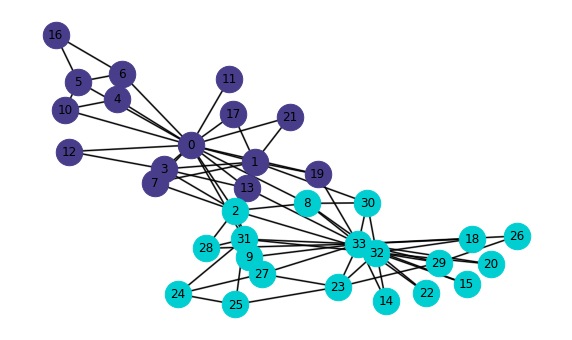

In [ ]:
num_coms = 2
clusters = KMeans(n_clusters=num_coms).fit_predict(embedding.detach().numpy())
communities = []
for i in range(num_coms):
  communities.append(set())
for i in range(len(clusters)):
  communities[clusters[i]].add(i)
fig = plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G) 
nx.draw_networkx(G, pos, with_labels=True)
colors = ['#483D8B', '#00CED1', '#FF4500', '#FFD700']
for i in range(num_coms):
  nx.draw_networkx_nodes(G, pos, node_size=700, nodelist=list(communities[i]), node_color=colors[i])
nx.draw_networkx_edges(G, pos, alpha=0.5, width=2)
plt.axis("off")
plt.show()